In [5]:
#import all necessary libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px
import os
import cv2
import itertools
import tensorflow as tf
import pydot
import graphviz

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# Set the path to your training and validation data
train_path = "C:\\pythonclass\\Students Assignments\\assigmentProject\\Odemosu project UK\\AI project\\Fruit detection data"
test_path = "C:\\pythonclass\\Students Assignments\\assigmentProject\\Odemosu project UK\\AI project\\Fruit detection data"

fresh_apple


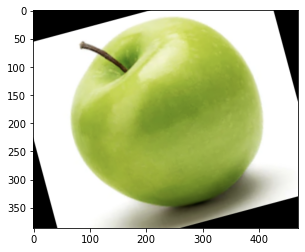

fresh_banana


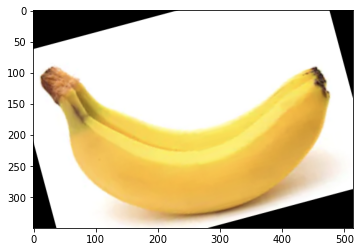

fresh_bitter_gourd


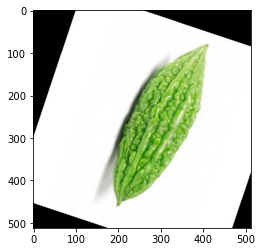

fresh_capsicum


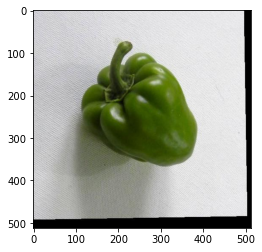

fresh_orange


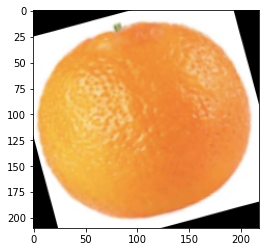

fresh_tomato


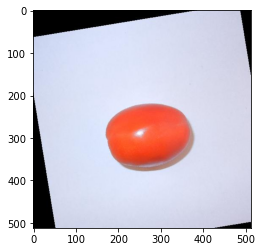

stale_apple


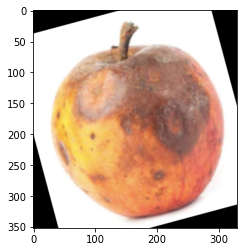

stale_banana


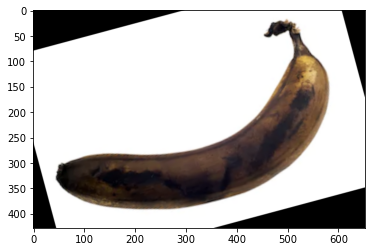

stale_bitter_gourd


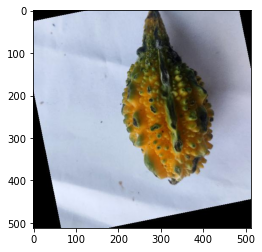

stale_capsicum


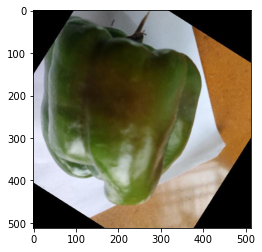

stale_orange


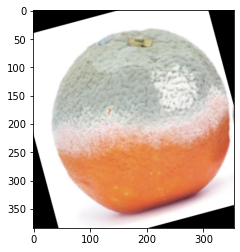

stale_tomato


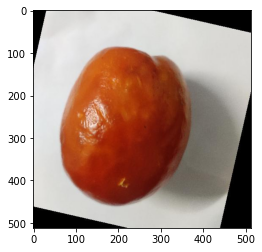

In [10]:
# Now we will navigate into the image folders to get the fruit images and then visualize the first image from different image folder.

for folder in os.listdir(test_path):
  sub_path = train_path +'/'+ folder

  print(folder)
  for i in range(1):
    temp_path = os.listdir(sub_path)[1]
    temp_path = sub_path +'/'+ temp_path
    img = mpimg.imread(temp_path)
    implot = plt.imshow(img)
    plt.show()

In [11]:
# After reading the images, we then create a function to convert the images into an array.
def imagearray(path, size):
  data = []
  for folder in os.listdir(path):
    sub_path = path + "/" + folder

    for img in os.listdir(sub_path):
      image_path = sub_path + "/" + img
      img_arr = cv2.imread(image_path)
      img_arr = cv2.resize(img_arr, size)
      data.append(img_arr)
  return data

In [12]:
size = (250, 250)

In [13]:
# Here, the images are converted to array and stored in the variable array
train = imagearray(train_path, size)

In [14]:
images = np.array(train)
# x_test = np.array(test)

In [15]:
# the images are then resized so that they maintain the same size for the training purpose   

images = images/255

In [16]:
print("x_train_shape", images.shape)

x_train_shape (14682, 250, 250, 3)


In [17]:
# The ImageGenerator is used for Data Augmentation, batch loading and class balancing
def data_class(data_path, size, class_mode):
  datagen = ImageDataGenerator(rescale = 1./255)
  classes = datagen.flow_from_directory(data_path,
                                        target_size = size,
                                        batch_size = 32,
                                        class_mode = class_mode)
  return classes

In [18]:
#this is used to get the classes for the image dataset and this classes will be alocated as labels for both the 
# training and validation data
train_class = data_class(train_path, size, 'sparse')

Found 14682 images belonging to 12 classes.


In [19]:
labels = train_class.classes

In [20]:
train_class.classes

array([ 0,  0,  0, ..., 11, 11, 11])

In [21]:
train_class.class_indices

{'fresh_apple': 0,
 'fresh_banana': 1,
 'fresh_bitter_gourd': 2,
 'fresh_capsicum': 3,
 'fresh_orange': 4,
 'fresh_tomato': 5,
 'stale_apple': 6,
 'stale_banana': 7,
 'stale_bitter_gourd': 8,
 'stale_capsicum': 9,
 'stale_orange': 10,
 'stale_tomato': 11}

In [22]:
# Now the feature (images) and labels (classes) are splited into train and test sets in the order of 80% and 20% respectively. Also, the split is generated randomly as specified in the code. 

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 1234)

In [23]:
print("y_train_shape", y_train.shape,
      "x_train_shape", x_train.shape,
      "y_test_shape", y_test.shape,
      "x_test_shape", x_test.shape)

y_train_shape (11745,) x_train_shape (11745, 250, 250, 3) y_test_shape (2937,) x_test_shape (2937, 250, 250, 3)


In [24]:
y_train = to_categorical(y_train, num_classes = 12)
y_test = to_categorical(y_test, num_classes = 12)

# **VGG19 Model**

In [25]:
vgg = VGG19(input_shape = (250, 250, 3), weights = 'imagenet', include_top = False)

In [26]:
for layer in vgg.layers:
  layer.trainable = False

In [27]:
num_classes = 12

x = Flatten()(vgg.output)
prediction = Dense(num_classes, activation = 'sigmoid')(x)

In [28]:
model = Model(inputs = vgg.input, outputs = prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

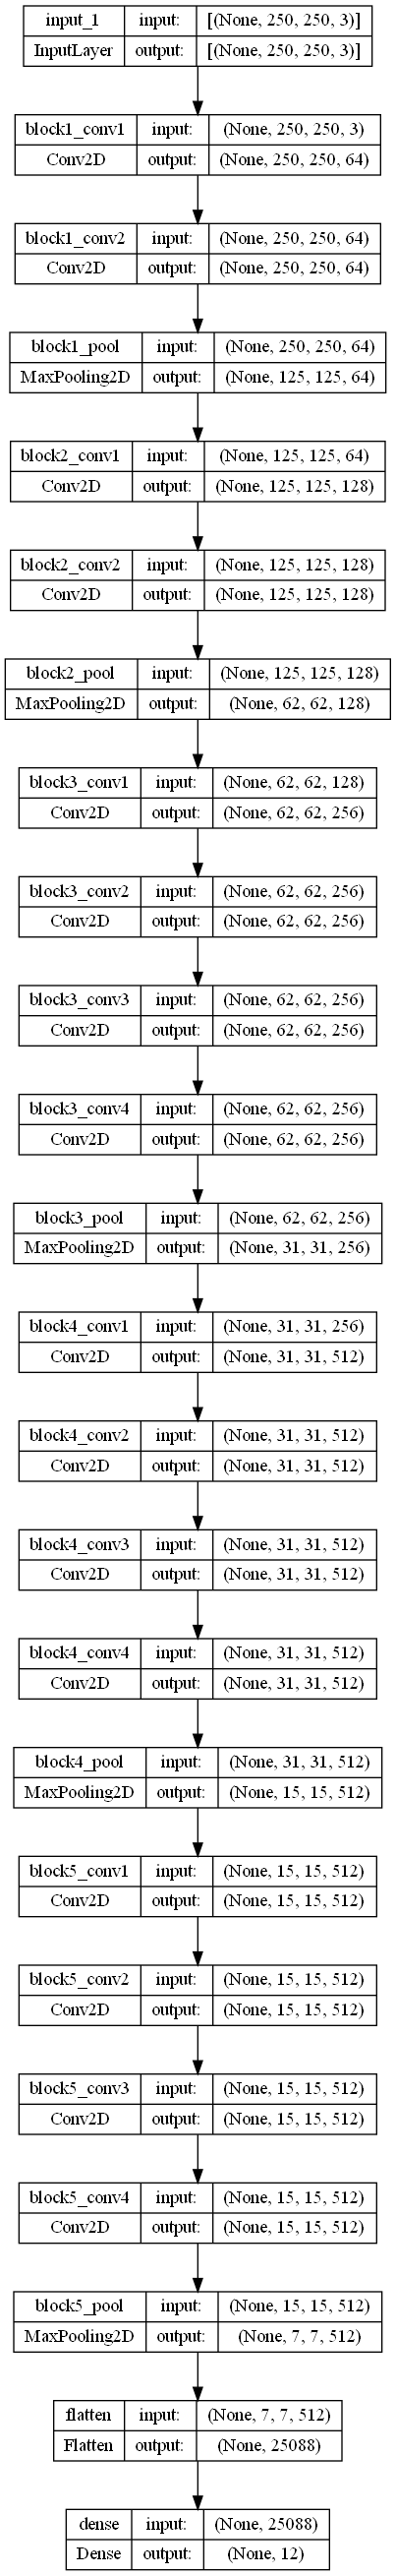

In [29]:
plot_model(model = model, show_shapes = True)

In [30]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

In [31]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [32]:
history = model.fit(x_train, y_train, validation_split = 0.1, epochs = 8, callbacks = [early_stop], batch_size = 10, shuffle = True)

Epoch 1/8
1057/1057 [==============================] - 3446s 3s/step - loss: 0.0621 - accuracy: 0.8935 - val_loss: 0.0309 - val_accuracy: 0.9515
Epoch 2/8
1057/1057 [==============================] - 31805s 30s/step - loss: 0.0190 - accuracy: 0.9797 - val_loss: 0.0231 - val_accuracy: 0.9702
Epoch 3/8
1057/1057 [==============================] - 2361s 2s/step - loss: 0.0115 - accuracy: 0.9894 - val_loss: 0.0159 - val_accuracy: 0.9830
Epoch 4/8
1057/1057 [==============================] - 2262s 2s/step - loss: 0.0111 - accuracy: 0.9906 - val_loss: 0.0334 - val_accuracy: 0.9711
Epoch 5/8
1057/1057 [==============================] - 2300s 2s/step - loss: 0.0081 - accuracy: 0.9940 - val_loss: 0.0165 - val_accuracy: 0.9813
Epoch 6/8
1057/1057 [==============================] - 2244s 2s/step - loss: 0.0063 - accuracy: 0.9960 - val_loss: 0.0121 - val_accuracy: 0.9881
Epoch 7/8
1057/1057 [==============================] - 2200s 2s/step - loss: 0.0069 - accuracy: 0.9949 - val_loss: 0.0154 - val_

# **Accuracy** **Test**   

**Visualization**

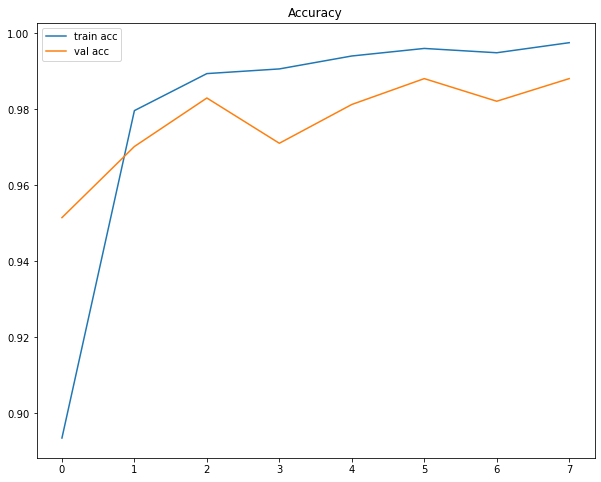

In [33]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

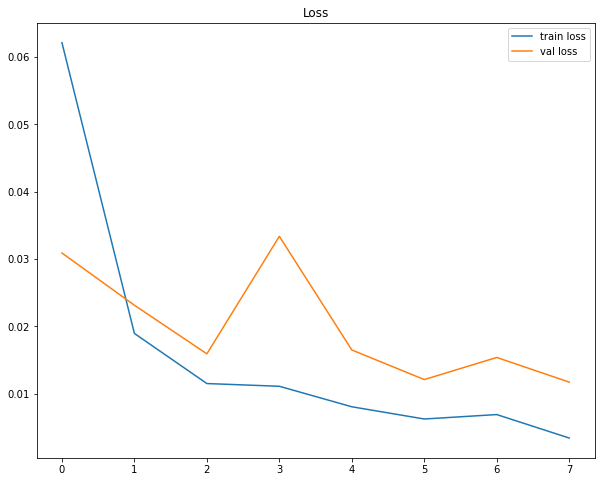

In [34]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# **Model Evaluation**

In [35]:
model.evaluate(x_test, y_test, batch_size=32)

92/92 [==============================] - 518s 6s/step - loss: 0.0129 - accuracy: 0.9860


[0.012899518013000488, 0.9860401749610901]

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_train, y_train, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

368/368 [==============================] - 13s 34ms/step - loss: 0.0588 - accuracy: 0.9215
Validation: accuracy = 0.921469  ;  loss_v = 0.058760
Test: accuracy = 0.818831  ;  loss = 0.159147


In [36]:
from sklearn.metrics import precision_recall_fscore_support

# load your test data and the predictions of the CNN model
y_pred = model.predict(x_test) # shape: (num_samples,)

# convert probabilities to class labels (0 or 1) based on a threshold of 0.5
y_pred = np.round(y_pred).astype(int)

# calculate precision, recall, and F1 score
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='samples')

# print the results
print('Precision:', precision)
print('Sensitivity:', recall)
print('F1 score:', f1_score)

92/92 [==============================] - 520s 6s/step
Precision: 0.9688457609805925
Sensitivity: 0.9741232550221314
F1 score: 0.9706049256611056


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 528s 6s/step


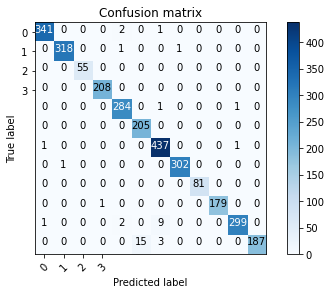

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4))

# **VGG16 Model**

In [23]:
# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

In [24]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [25]:
# Create a new model
model = Sequential()
# Add the base model as a layer
model.add(base_model)

In [26]:
# Add custom layers on top of the base model
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [27]:
num_classes = 12

x = Flatten()(base_model.output)
prediction = Dense(num_classes, activation = 'sigmoid')(x)

In [28]:
model = Model(inputs = base_model.input, outputs = prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0   

In [29]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

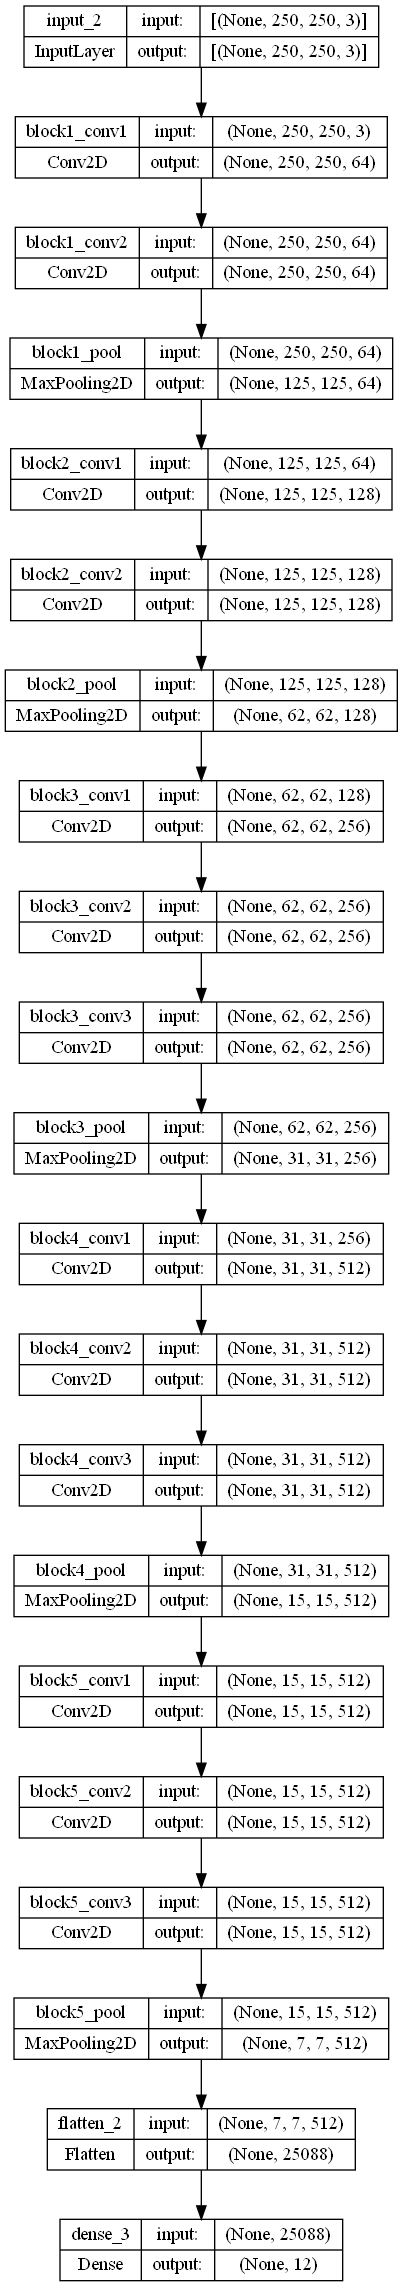

In [30]:
plot_model(model = model, show_shapes = True)

In [31]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

In [32]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [33]:
history = model.fit(x_train, y_train, validation_split = 0.1, epochs = 10, callbacks = [early_stop], batch_size = 10, shuffle = True)

Epoch 1/10
1057/1057 [==============================] - 1828s 2s/step - loss: 0.0580 - accuracy: 0.8959 - val_loss: 0.0275 - val_accuracy: 0.9634
Epoch 2/10
1057/1057 [==============================] - 1752s 2s/step - loss: 0.0155 - accuracy: 0.9802 - val_loss: 0.0235 - val_accuracy: 0.9634
Epoch 3/10
1057/1057 [==============================] - 1791s 2s/step - loss: 0.0098 - accuracy: 0.9901 - val_loss: 0.0278 - val_accuracy: 0.9651
Epoch 4/10
1057/1057 [==============================] - 1838s 2s/step - loss: 0.0067 - accuracy: 0.9934 - val_loss: 0.0128 - val_accuracy: 0.9872
Epoch 5/10
1057/1057 [==============================] - 1809s 2s/step - loss: 0.0056 - accuracy: 0.9951 - val_loss: 0.0181 - val_accuracy: 0.9847
Epoch 6/10
1057/1057 [==============================] - 1847s 2s/step - loss: 0.0043 - accuracy: 0.9968 - val_loss: 0.0104 - val_accuracy: 0.9881
Epoch 7/10
1057/1057 [==============================] - 1814s 2s/step - loss: 0.0055 - accuracy: 0.9961 - val_loss: 0.0177 -

# **Accuracy** **Test**   

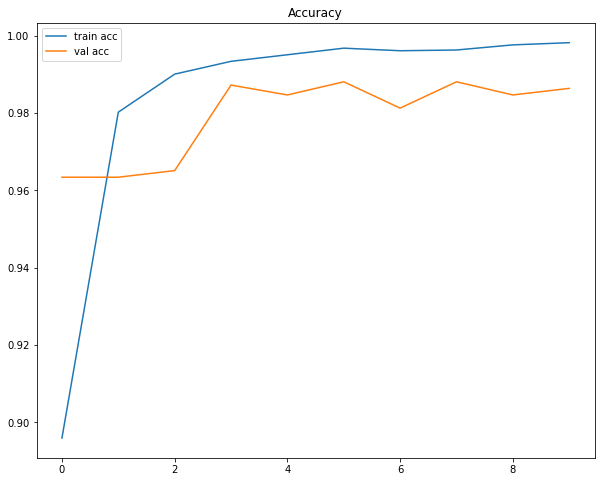

In [34]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

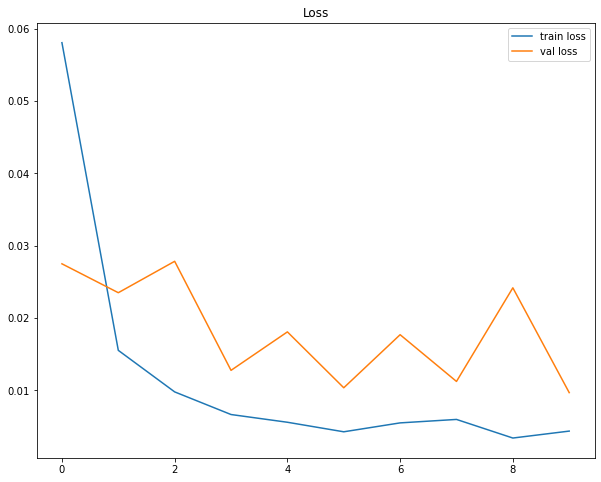

In [35]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# **Model Evaluation**

In [36]:
model.evaluate(x_test, y_test, batch_size=32)

92/92 [==============================] - 401s 4s/step - loss: 0.0119 - accuracy: 0.9847


[0.011865055188536644, 0.9846782684326172]

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_train, y_train, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

92/92 [==============================] - 409s 4s/step - loss: 0.0119 - accuracy: 0.9847


In [38]:
from sklearn.metrics import precision_recall_fscore_support

# load your test data and the predictions of the CNN model
y_pred = model.predict(x_test) # shape: (num_samples,)

# convert probabilities to class labels (0 or 1) based on a threshold of 0.5
y_pred = np.round(y_pred).astype(int)

# calculate precision, recall, and F1 score
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='samples')

# print the results
print('Precision:', precision)
print('Sensitivity:', recall)
print('F1 score:', f1_score)

92/92 [==============================] - 523s 6s/step
Precision: 0.9688457609805925
Sensitivity: 0.9741232550221314
F1 score: 0.9706049256611056


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 538s 6s/step


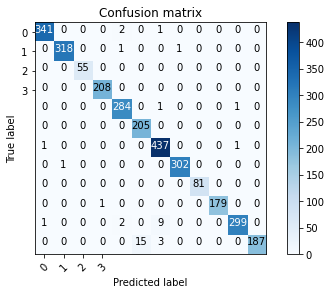

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4))